# Import Packages

In [15]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from scipy.optimize import linear_sum_assignment
warnings.filterwarnings("ignore", category=UserWarning)
import os, json, joblib
from pathlib import Path
import umap

import umap
import joblib

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
_analyzer = SentimentIntensityAnalyzer()

# Load Data

In [16]:
df_cleaned = pd.read_csv("cleaned_tweets.csv")
texts = df_cleaned["clean_text"].astype(str).tolist()

df_cleaned_sample = pd.read_csv("cleaned_sample_tweets.csv")

# Traditional Feature Extraction

In [17]:
# -------------------------------
# Helpers: features + metrics
# -------------------------------
def _count_emojis(s: str) -> int:
    return sum(ch in emoji.EMOJI_DATA for ch in s)

def _safe_ratio(num, den):
    den = den if den > 0 else 1
    return float(num) / float(den)

_DEFAULT_POS = {"good","great","amazing","love","loved","awesome","thanks","thank","best","upgrade","nice","happy"}
_DEFAULT_NEG = {"bad","worst","delay","delayed","late","hate","horrible","terrible","lost","cancel","canceled","cancellation","angry","sad"}

def extract_features(texts, version="v1", pos_lex=None, neg_lex=None):
    """
    v1 = ["word_count","avg_word_len","exclam_count","ques_count","upper_count","emoji_count","vader_compound"]
    v2 = v1 + ["exclam_ratio","ques_ratio","vader_pos","vader_neu","vader_neg","pos_lex_cnt","neg_lex_cnt","neg_pos_lex_ratio"]
    """
    if pos_lex is None: pos_lex = _DEFAULT_POS
    if neg_lex is None: neg_lex = _DEFAULT_NEG
    feats = []
    for s in texts:
        s = s if isinstance(s, str) else str(s)
        s_strip = s.strip()

        exclam_count = s_strip.count('!')
        ques_count   = s_strip.count('?')
        emoji_count  = _count_emojis(s_strip)

        tokens = s_strip.split()
        word_count = sum(1 for t in tokens if any(ch.isalpha() for ch in t))
        alpha_tokens = [''.join(ch for ch in t if ch.isalpha()) for t in tokens if any(ch.isalpha() for ch in t)]
        avg_word_len = (sum(len(t) for t in alpha_tokens) / len(alpha_tokens)) if alpha_tokens else 0.0
        upper_count  = sum(1 for t in tokens if t.isupper() and len(t) >= 2)

        vs = _analyzer.polarity_scores(s_strip)
        vader_pos, vader_neu, vader_neg, vader_compound = vs["pos"], vs["neu"], vs["neg"], vs["compound"]

        exclam_ratio = _safe_ratio(exclam_count, word_count)
        ques_ratio   = _safe_ratio(ques_count, word_count)

        lowered = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in tokens]
        pos_lex_cnt = sum(1 for t in lowered if t in pos_lex)
        neg_lex_cnt = sum(1 for t in lowered if t in neg_lex)
        neg_pos_lex_ratio = _safe_ratio(neg_lex_cnt, pos_lex_cnt)

        row_v1 = [float(word_count), float(avg_word_len), float(exclam_count),
                  float(ques_count), float(upper_count), float(emoji_count), float(vader_compound)]

        if version == "v1":
            feats.append(row_v1)
        elif version == "v2":
            row_v2 = row_v1 + [float(exclam_ratio), float(ques_ratio),
                               float(vader_pos), float(vader_neu), float(vader_neg),
                               float(pos_lex_cnt), float(neg_lex_cnt), float(neg_pos_lex_ratio)]
            feats.append(row_v2)
        else:
            raise ValueError("version must be 'v1' or 'v2'")
    return np.asarray(feats, dtype=np.float32)

def clustering_accuracy(y_true_int, y_pred_int):
    cm = confusion_matrix(y_true_int, y_pred_int)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_all(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = clustering_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# --------------------------------------
# Data + label encoding (stable mapping)
# --------------------------------------
texts_sample = df_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_cleaned["clean_text"].astype(str).tolist()

le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))

# --------------------
# Configs 
# --------------------
feature_versions = ["v1", "v2"]
gmm_cov_types    = ["full", "tied", "diag", "spherical"]
agg_linkages     = ["average", "complete", "single"]

# results containers
df_tuning_rows = []   # subset (silhouette only)
df_best_rows   = []   # best per model per feature set
df_final_rows  = []   # full data with all metrics

# ==========================================================
# Caching: save model + tables on first run; on later runs load & display
# ==========================================================
os.makedirs("model", exist_ok=True)
FINAL_PKL   = "model/tfe_pipeline.pkl"
FINAL_META  = "model/tfe_pipeline_meta.json"
FINAL_TUNE  = "model/df_tuning.csv"
FINAL_BEST  = "model/df_best.csv"
FINAL_TABLE = "model/df_final.csv"

def _print_all_tables_and_winners(df_tuning, df_best, df_final):
    # Tables
    print("\n================ Tuning (20% subset): all parameters & silhouette ================")
    print(df_tuning.sort_values(
        ["Feature_Set","Reducer","Model","Silhouette"],
        ascending=[True, True, True, False]
    ).to_string(index=False))

    print("\n================ Best Parameters per Branch (20% subset) ================")
    print(df_best.sort_values(["Feature_Set","Reducer","Model"]).to_string(index=False))

    print("\n================ Final Evaluation on Full Cleaned Data (All 6 best models) ================")
    print(df_final.sort_values(["Feature_Set","Reducer","Model"]).to_string(index=False))

    # Winners
    for metric in ["Silhouette","ARI","NMI","Hungarian"]:
        r = df_final.loc[df_final[metric].idxmax()]
        print(f"\nWinner by {metric}: {r['Feature_Set']}+{r['Model']} | {metric}={r[metric]:.3f} | {r['Param']}")

# If cached artifacts exist, load and display everything without retraining
if (Path(FINAL_PKL).exists()
    and Path(FINAL_META).exists()
    and Path(FINAL_TUNE).exists()
    and Path(FINAL_BEST).exists()
    and Path(FINAL_TABLE).exists()):
    print("Loading cached traditional-feature model and saved result tables...")
    winner_pack = joblib.load(FINAL_PKL)
    with open(FINAL_META, "r") as f:
        meta = json.load(f)

    # Load saved tables
    df_tuning = pd.read_csv(FINAL_TUNE)
    df_best   = pd.read_csv(FINAL_BEST)
    df_final  = pd.read_csv(FINAL_TABLE)

    # Echo meta (quick summary) then print full tables + winners
    print(f"Loaded cached model → {FINAL_PKL}")
    print(f"Winner: {meta['feature_version']} + {meta['model_type']} | "
          f"Silhouette={meta['metrics']['Silhouette']:.3f} | "
          f"ARI={meta['metrics']['ARI']:.3f} | "
          f"NMI={meta['metrics']['NMI']:.3f} | "
          f"Hungarian={meta['metrics']['Hungarian']:.3f}")

    _print_all_tables_and_winners(df_tuning, df_best, df_final)

else:
    print("Running full classic feature training (first time)...")

    # ---------- BEGIN ORIGINAL TRAIN LOOP ----------
    models_by_key = {}   # (Feature_Set, Model) -> packed fitted objects
    df_tuning_rows, df_best_rows, df_final_rows = [], [], []

    for version in feature_versions:
        print(f"\n=== Feature set: {version} (no DR) ===")

        # features
        Xs = extract_features(texts_sample, version=version)
        Xf = extract_features(texts_full,   version=version)

        # standardize & repr
        scaler_s = StandardScaler().fit(Xs)
        Xs_std   = scaler_s.transform(Xs).astype(np.float64)
        Xs_l2    = normalize(Xs_std, norm="l2")

        scaler_f = StandardScaler().fit(Xf)
        Xf_std   = scaler_f.transform(Xf).astype(np.float64)
        Xf_l2    = normalize(Xf_std, norm="l2")

        # --- KMeans (subset + full) ---
        kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
        lab_s  = kmeans.fit_predict(Xs_l2)
        sil_s  = silhouette_score(Xs_l2, lab_s, metric="cosine")
        df_tuning_rows.append([version, "None", "KMeans", "-", sil_s])
        df_best_rows.append([version, "None", "KMeans", "-", sil_s])

        kmeans_full = KMeans(n_clusters=3, n_init=10, random_state=42).fit(Xf_l2)
        lab_f = kmeans_full.labels_
        sil, ari, nmi, acc = evaluate_all(Xf_l2, y_full_enc, lab_f, sil_metric="cosine")
        df_final_rows.append([version, "None", "KMeans", "-", sil, ari, nmi, acc])
        models_by_key[(version, "KMeans")] = {
            "feature_version": version,
            "preprocess": {"scaler": scaler_f, "repr": "l2"},
            "model_type": "KMeans",
            "estimator": kmeans_full,
            "sil_metric": "cosine"
        }

        # --- GMM (subset tune + full) ---
        best_gmm = (None, -np.inf)
        for cov in ["full", "tied", "diag", "spherical"]:
            gmm   = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type=cov)
            lab_s = gmm.fit_predict(Xs_std)
            sil_s = silhouette_score(Xs_std, lab_s, metric="euclidean")
            df_tuning_rows.append([version, "None", "GMM", cov, sil_s])
            if sil_s > best_gmm[1]:
                best_gmm = (cov, sil_s)
        df_best_rows.append([version, "None", "GMM", best_gmm[0], best_gmm[1]])

        gmm_full = GaussianMixture(n_components=3, n_init=10, random_state=42,
                                   covariance_type=best_gmm[0]).fit(Xf_std)
        lab_f = gmm_full.predict(Xf_std)
        sil, ari, nmi, acc = evaluate_all(Xf_std, y_full_enc, lab_f, sil_metric="euclidean")
        df_final_rows.append([version, "None", "GMM", best_gmm[0], sil, ari, nmi, acc])
        models_by_key[(version, "GMM")] = {
            "feature_version": version,
            "preprocess": {"scaler": scaler_f, "repr": "std"},
            "model_type": "GMM",
            "estimator": gmm_full,
            "gmm_covariance_type": best_gmm[0],
            "sil_metric": "euclidean"
        }

        # --- Agglo (subset tune + full) ---
        def _agglo(metric_or_affinity, linkage, n_clusters=3):
            try:
                return AgglomerativeClustering(n_clusters=n_clusters, metric=metric_or_affinity, linkage=linkage)
            except TypeError:
                return AgglomerativeClustering(n_clusters=n_clusters, affinity=metric_or_affinity, linkage=linkage)

        best_agg = (None, -np.inf)
        for link in ["average", "complete", "single"]:
            agg   = _agglo("cosine", link, n_clusters=3)
            lab_s = agg.fit_predict(Xs_l2)
            sil_s = silhouette_score(Xs_l2, lab_s, metric="cosine")
            df_tuning_rows.append([version, "None", "Agglo", link, sil_s])
            if sil_s > best_agg[1]:
                best_agg = (link, sil_s)
        df_best_rows.append([version, "None", "Agglo", best_agg[0], best_agg[1]])

        agg_full = _agglo("cosine", best_agg[0], n_clusters=3).fit(Xf_l2)
        lab_f = agg_full.labels_
        sil, ari, nmi, acc = evaluate_all(Xf_l2, y_full_enc, lab_f, sil_metric="cosine")
        df_final_rows.append([version, "None", "Agglo", best_agg[0], sil, ari, nmi, acc])
        models_by_key[(version, "Agglo")] = {
            "feature_version": version,
            "preprocess": {"scaler": scaler_f, "repr": "l2"},
            "model_type": "Agglo",
            "estimator": agg_full,
            "agg_linkage": best_agg[0],
            "sil_metric": "cosine"
        }

    # Build tables
    df_tuning = pd.DataFrame(df_tuning_rows, columns=["Feature_Set","Reducer","Model","Param","Silhouette"])
    df_best   = pd.DataFrame(df_best_rows,   columns=["Feature_Set","Reducer","Model","Best_Param","Best_Silhouette"])
    df_final  = pd.DataFrame(df_final_rows,  columns=["Feature_Set","Reducer","Model","Param","Silhouette","ARI","NMI","Hungarian"])

    # Display (same behavior as cached path)
    _print_all_tables_and_winners(df_tuning, df_best, df_final)

    # Pick overall winner (multi-metric sort) and SAVE model + meta (as you had)
    sort_cols = ["Hungarian", "ARI", "NMI", "Silhouette"]
    winner_row = df_final.sort_values(sort_cols, ascending=[False]*4).iloc[0]
    winner_key   = (winner_row["Feature_Set"], winner_row["Model"])
    winner_pack  = models_by_key[winner_key]

    joblib.dump(winner_pack, FINAL_PKL)
    meta = {
        "feature_version": winner_pack["feature_version"],
        "model_type": winner_pack["model_type"],
        "param": str(winner_row["Param"]),
        "sil_metric": winner_pack["sil_metric"],
        "metrics": {
            "Silhouette": float(winner_row["Silhouette"]),
            "ARI": float(winner_row["ARI"]),
            "NMI": float(winner_row["NMI"]),
            "Hungarian": float(winner_row["Hungarian"])
        }
    }
    with open(FINAL_META, "w") as f:
        json.dump(meta, f, indent=2)

    print(f"\nSaved new model → {FINAL_PKL}")
    print(f"Meta → {FINAL_META}")
    print(f"Tables → {FINAL_TUNE}, {FINAL_BEST}, {FINAL_TABLE}")
    print(f"Winner: {winner_key} | {meta}")

Running full classic feature training (first time)...

=== Feature set: v1 (no DR) ===

=== Feature set: v2 (no DR) ===

================ Tuning (20% subset): all parameters & silhouette ================
Feature_Set Reducer  Model     Param  Silhouette
         v1    None  Agglo   average    0.344664
         v1    None  Agglo  complete    0.344080
         v1    None  Agglo    single   -0.090795
         v1    None    GMM      diag    0.212222
         v1    None    GMM      full    0.195763
         v1    None    GMM      tied    0.191331
         v1    None    GMM spherical    0.156560
         v1    None KMeans         -    0.393412
         v2    None  Agglo   average    0.329216
         v2    None  Agglo  complete    0.308838
         v2    None  Agglo    single   -0.138342
         v2    None    GMM      tied    0.232809
         v2    None    GMM      diag    0.186877
         v2    None    GMM spherical    0.136919
         v2    None    GMM      full    0.119088
         v2 

# Visualisation

Best model (by Hungarian): v2 + KMeans
Params: -
Metrics: {'Silhouette': 0.3838943582039736, 'ARI': 0.11903971549561239, 'NMI': 0.15997294931482964, 'Hungarian': 0.5496960174875333}


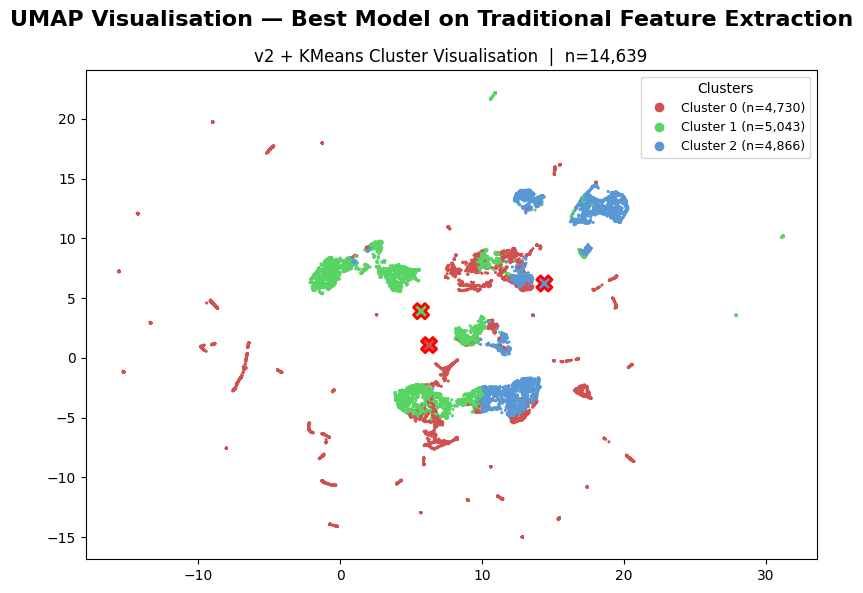

In [18]:
# ===========================
# Visualise the best saved traditional-feature model (Hungarian winner)
# ===========================


RANDOM_STATE = 42
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue

# ---- Paths for the traditional-feature (TFE) artifacts ----
META_JSON = "model/tfe_pipeline_meta.json"
PIPE_PATH = "model/tfe_pipeline.pkl"

# ---- Load saved artifacts ----
with open(META_JSON, "r") as f:
    meta = json.load(f)

print(f"Best model (by Hungarian): {meta['feature_version']} + {meta['model_type']}")
print("Params:", meta.get("param", "-"))
print("Metrics:", meta["metrics"])

winner_pack = joblib.load(PIPE_PATH)

# winner_pack structure (from training code):
# {
#   "feature_version": ...,
#   "preprocess": {"scaler": <StandardScaler>, "repr": "l2" or "std"},
#   "model_type": "KMeans" | "GMM" | "Agglo",
#   "estimator": <fitted estimator>,
#   "sil_metric": "cosine" | "euclidean",
#   ... (branch-specific fields)
# }

# ---- Rebuild features on FULL TEXTS and apply saved preprocessing ----
version = winner_pack["feature_version"]
scaler  = winner_pack["preprocess"]["scaler"]
repr_   = winner_pack["preprocess"]["repr"]
sil_metric = winner_pack["sil_metric"]
est     = winner_pack["estimator"]

# texts_full is assumed to be defined earlier in your notebook
X_raw = extract_features(texts_full, version=version)
X_std = scaler.transform(X_raw).astype(np.float64)
X_use = normalize(X_std, norm="l2") if repr_ == "l2" else X_std

# ---- Get labels (Agglo/KMeans have labels_, GMM needs predict) ----
if hasattr(est, "labels_") and getattr(est, "labels_") is not None:
    labels = est.labels_
else:
    labels = est.predict(X_use)

# ---------------------------
# Reduce to 2D for plotting
# ---------------------------
umap_metric = "cosine" if sil_metric == "cosine" else "euclidean"
umap_2d = umap.UMAP(
    n_neighbors=50, min_dist=0.1, n_components=2,
    metric=umap_metric, random_state=RANDOM_STATE
)
X_vis = umap_2d.fit_transform(X_use)

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Robust color mapping (handles arbitrary label sets)
unique_labels = np.unique(labels)
color_map = {k: palette[i % len(palette)] for i, k in enumerate(unique_labels)}
point_colors = [color_map[k] for k in labels]

ax.scatter(X_vis[:, 0], X_vis[:, 1], c=point_colors, s=5, edgecolor="none")

# Legend with counts
_, counts = np.unique(labels, return_counts=True)
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=f"Cluster {k} (n={counts[i]:,})",
               markerfacecolor=color_map[k], markersize=8)
    for i, k in enumerate(unique_labels)
]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)

# Centroids in the visual space
centroids = np.vstack([X_vis[labels == k].mean(axis=0) for k in unique_labels])
ax.scatter(centroids[:, 0], centroids[:, 1], s=120, marker="X",
           c=[color_map[k] for k in unique_labels],
           edgecolor="red", linewidth=2.0, zorder=3)

# Titles
branch_name = f"{meta['feature_version']} + {meta['model_type']}"
ax.set_title(f"{branch_name} Cluster Visualisation  |  n={len(labels):,}", fontsize=12)
plt.suptitle("UMAP Visualisation — Best Model on Traditional Feature Extraction", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()